## NumPy NN starter: 2-input, 1 hidden layer, 1 output (binary)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## --- Load dataset and pick two features (change indices as needed) ---

In [17]:
data = load_breast_cancer()
X_full = data.data
y_full = data.target.reshape(-1,1)

## Select two features (e.g., mean radius (0) and mean texture (1))

In [18]:
feat_idx = [0, 1]
X = X_full[:, feat_idx]

## Standardize

In [19]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Train/test split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y_full, test_size=0.2, random_state=1)

## --- Network architecture --

In [21]:
n_x = X_train.shape[1]   # 2
n_h = 4                  # hidden units (choose 2-4)
n_y = 1

# --- Activation functions ---

In [22]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_deriv(a):
    return a * (1 - a)

def relu(z):
    return np.maximum(0, z)

def relu_deriv(z):
    return (z > 0).astype(float)

hidden_activation = 'relu'  # 'relu'

## --- Parameter initialization (Xavier for sigmoid/tanh, He for relu) ---

In [23]:
def init_params(seed=42):
    rng = np.random.RandomState(seed)
    if hidden_activation == 'relu':
        W1 = rng.randn(n_x, n_h) * np.sqrt(2. / n_x)
    else:
        W1 = rng.randn(n_x, n_h) * np.sqrt(1. / n_x)
    b1 = np.zeros((1, n_h))
    W2 = rng.randn(n_h, n_y) * np.sqrt(1. / n_h)
    b2 = np.zeros((1, n_y))
    return W1, b1, W2, b2

In [24]:
W1, b1, W2, b2 = init_params()

## --- Forward propagation ---

In [25]:
def forward(X):
    Z1 = X.dot(W1) + b1         # (m, n_h)
    if hidden_activation == 'relu':
        A1 = relu(Z1)
    else:
        A1 = sigmoid(Z1)
    Z2 = A1.dot(W2) + b2        # (m, 1)
    A2 = sigmoid(Z2)            # output activation sigmoid for binary
    cache = (X, Z1, A1, Z2, A2)
    return A2, cache

## --- Compute MSE loss ---

In [26]:
def compute_loss(A2, Y):
    m = Y.shape[0]
    loss = np.mean((A2 - Y)**2)
    return loss

## --- Backpropagation (MSE + sigmoid output) ---

In [27]:
def backward(cache, A2, Y):
    X, Z1, A1, Z2, _ = cache
    m = X.shape[0]
    # dLoss/dA2 = 2*(A2 - Y)/m
    dA2 = 2 * (A2 - Y) / m
    # output layer gradients (sigmoid)
    dZ2 = dA2 * sigmoid_deriv(A2)        # (m,1)
    dW2 = A1.T.dot(dZ2)                  # (n_h, 1)
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    # hidden layer gradients
    dA1 = dZ2.dot(W2.T)                  # (m, n_h)
    if hidden_activation == 'relu':
        dZ1 = dA1 * relu_deriv(Z1)
    else:
        dZ1 = dA1 * sigmoid_deriv(A1)
    dW1 = X.T.dot(dZ1)                   # (n_x, n_h)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    grads = (dW1, db1, dW2, db2)
    return grads

## --- Update parameters ---

In [28]:
def update_params(params, grads, lr):
    W1, b1, W2, b2 = params
    dW1, db1, dW2, db2 = grads
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
    return W1, b1, W2, b2

## --- Training loop ---

In [29]:
def train(X, Y, iterations=800, lr=0.05, print_every=100):
    global W1, b1, W2, b2
    params = (W1, b1, W2, b2)
    losses = []
    for i in range(iterations):
        A2, cache = forward(X)
        loss = compute_loss(A2, Y)
        grads = backward(cache, A2, Y)
        params = update_params(params, grads, lr)
        W1, b1, W2, b2 = params
        losses.append(loss)
        if (i+1) % print_every == 0 or i==0:
            print(f"Iter {i+1}/{iterations} — loss: {loss:.6f}")
    return losses

## Train

In [30]:
losses = train(X_train, y_train, iterations=1000, lr=0.05, print_every=200)

Iter 1/1000 — loss: 0.204422
Iter 200/1000 — loss: 0.112362
Iter 400/1000 — loss: 0.088395
Iter 600/1000 — loss: 0.078742
Iter 800/1000 — loss: 0.073664
Iter 1000/1000 — loss: 0.070550


## --- Evaluate ---

In [31]:
def predict(X):
    A2, _ = forward(X)
    return (A2 >= 0.5).astype(int)

train_pred = predict(X_train)
test_pred = predict(X_test)
train_acc = (train_pred == y_train).mean()
test_acc = (test_pred == y_test).mean()
print(f"Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9055, Test accuracy: 0.8596


## --- Plot loss ---

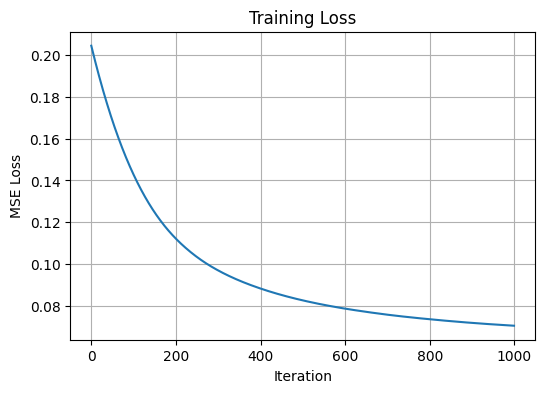

In [32]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

## --- Decision boundary (only for 2D input) ---

In [33]:
def plot_decision_boundary(X, y):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min,x_max,200), np.linspace(y_min,y_max,200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = predict(grid)
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), edgecolors='k', s=40)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.show()

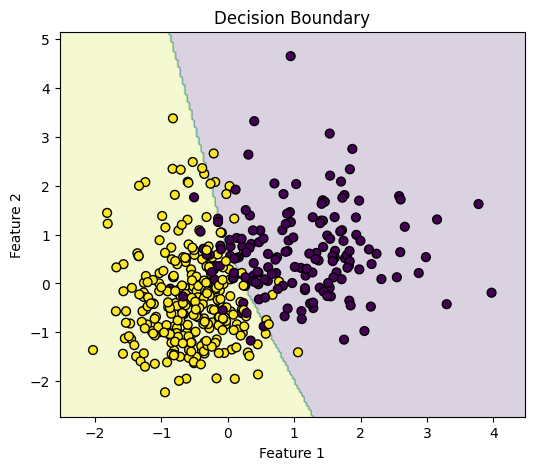

In [34]:
plot_decision_boundary(X_train, y_train)